# marker

In [1]:
import numpy as np
import pandas as pd

from config import CONFIG

In [2]:
markerV4File = CONFIG.DataRaw / 'Cancer12MarkerV4.xlsx'
markerDir = CONFIG.DataRaw / 'markerV4'

cellInfo=pd.read_csv(CONFIG.DataRaw/'CellInfo.csv',sep=',')
cellInfo=cellInfo[cellInfo['QCFailed2'].isna()]
cellInfo=cellInfo[~cellInfo['SubjectType'].isna()]

def addMarker(dfSample):
    marker = CONFIG.DataRaw / 'Cancer12MarkerV4.xlsx'
    dfMarker = pd.read_excel(marker)
    dfSample.columns = ['chrom', 'start', 'end', 'methylation_level']
    dfSample = dfSample.drop_duplicates(subset=['chrom', 'start', 'end'], ignore_index=True)
    return pd.merge(dfMarker, dfSample, how='left', on=['chrom', 'start', 'end'])

colHeaders = None
samples=[]
sampleNames = []
for marker in markerDir.glob('*.markerV4.bed'):
    dfSample = pd.read_csv(marker, sep='\t')
    dfSample.replace(-1, np.nan, inplace=True)
    sample=addMarker(dfSample)
    if colHeaders is None:
        colHeaders = sample.iloc[:,0:sample.columns.size-1]
    samples.append(sample.iloc[:, sample.columns.size-1])
    sampleNames.append(marker.stem.split('.')[0])
dfSamples=pd.concat(samples,axis=1)
dfSamples.columns=sampleNames
dfSamples=dfSamples.reindex(columns=cellInfo['DataID'].tolist(), fill_value=np.nan)
dfSamplesWithMarker=pd.concat([colHeaders,dfSamples],axis=1)

In [3]:
lung=dfSamplesWithMarker[dfSamplesWithMarker['abbr']=='NSCLC']
mm=lung.iloc[:,9:]
mm.columns=cellInfo['SubjectID']
mm.index=lung['Gene']

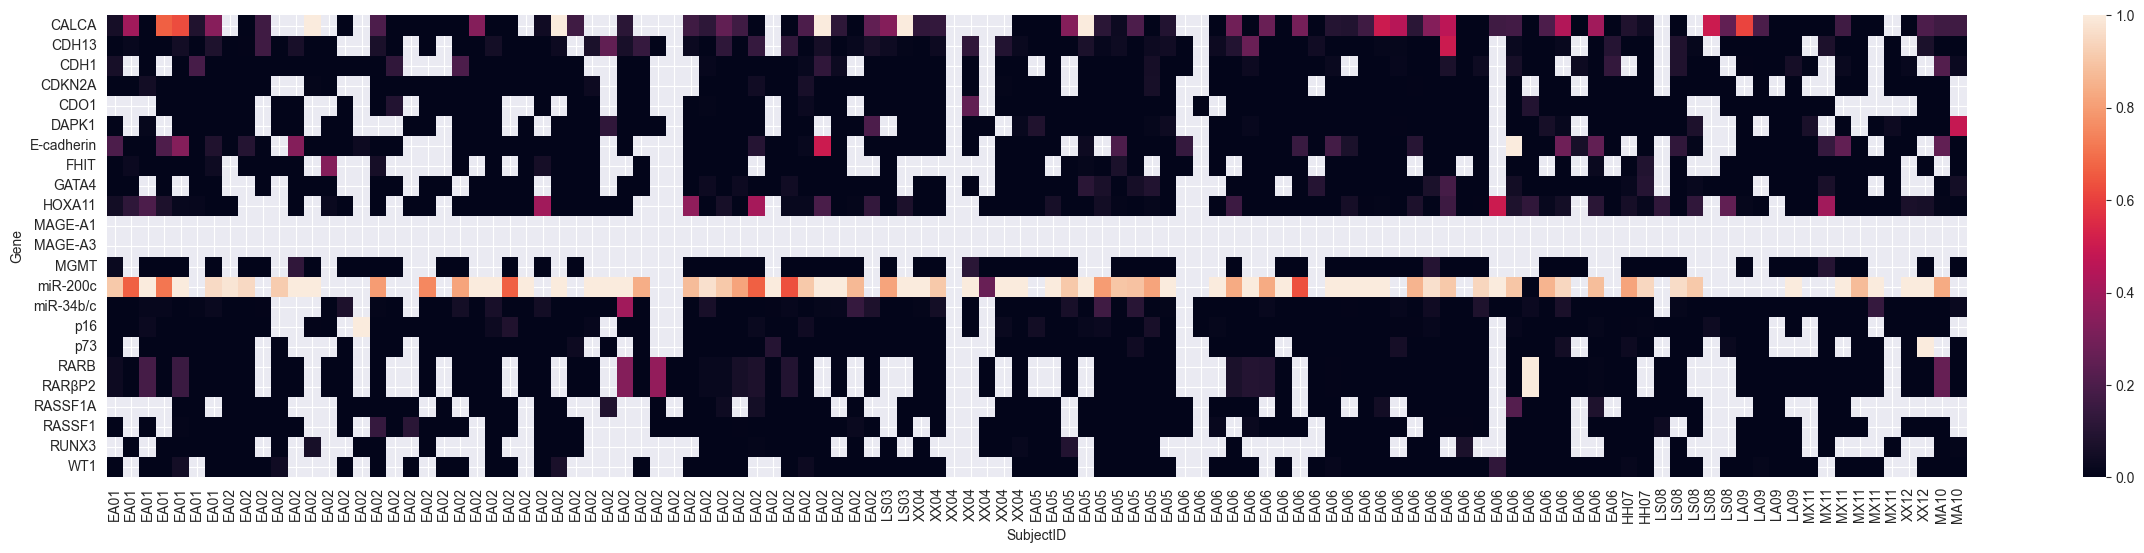

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

mm.columns=cellInfo['SubjectID']
plt.figure(figsize=(30, 6))
sns.heatmap(mm)
plt.show()

<Figure size 3000x600 with 0 Axes>

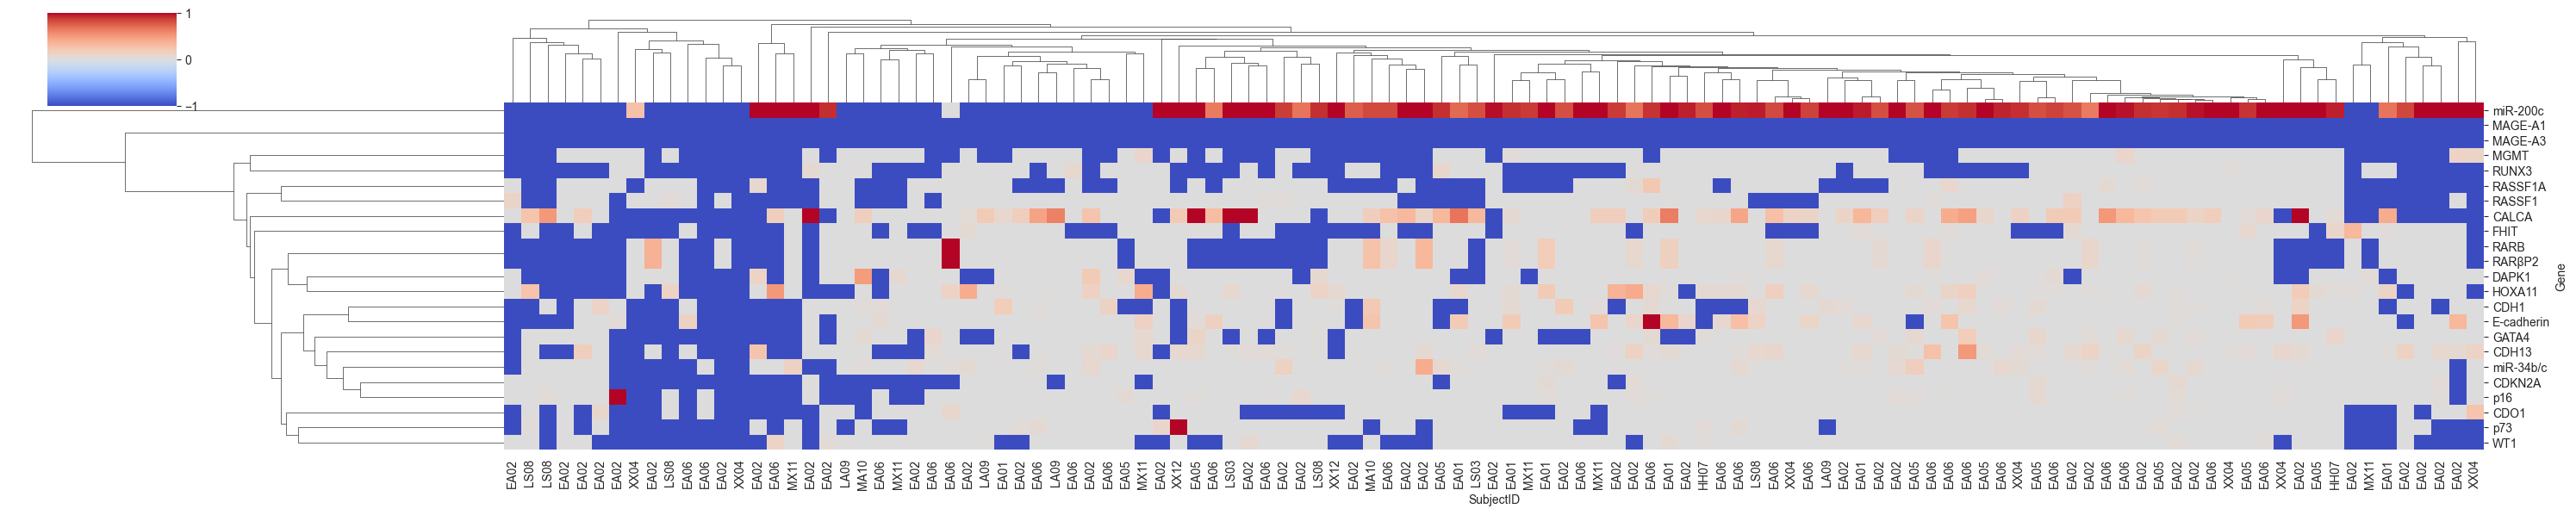

In [5]:
import scipy.stats as stats

mm2=mm.replace(np.nan, -1)

plt.figure(figsize=(30, 6))

g=sns.clustermap(mm2, cmap='coolwarm', figsize=(30, 6))
g.savefig(CONFIG.DataDir/'result'/'marker.heatmap.pdf')
# 显示图形
#plt.show()


In [26]:
def get_marker_positive(target):
    lungHyper=lung['hyper'].reset_index(drop=True)
    target=target.reset_index(drop=True)
    sampleLung=pd.concat([lungHyper, target],axis=1)
    sampleLung=sampleLung[~sampleLung.iloc[:,1].isna()]
    positive=(sampleLung['hyper']==1) & (sampleLung.iloc[:,1] >0.5)
    return positive.sum(),len(sampleLung)

In [31]:
positive_markers=[]
for idx in range(mm.shape[1]):
    positive, total = get_marker_positive(mm.iloc[:,idx])
    positive_markers.append([mm.columns[idx],positive, total])

In [32]:
dfSampleLung=pd.DataFrame(positive_markers)
dfSampleLung.columns=['subject', 'positive', 'total']
dfSampleLung['ratio']=dfSampleLung['positive']/dfSampleLung['total']


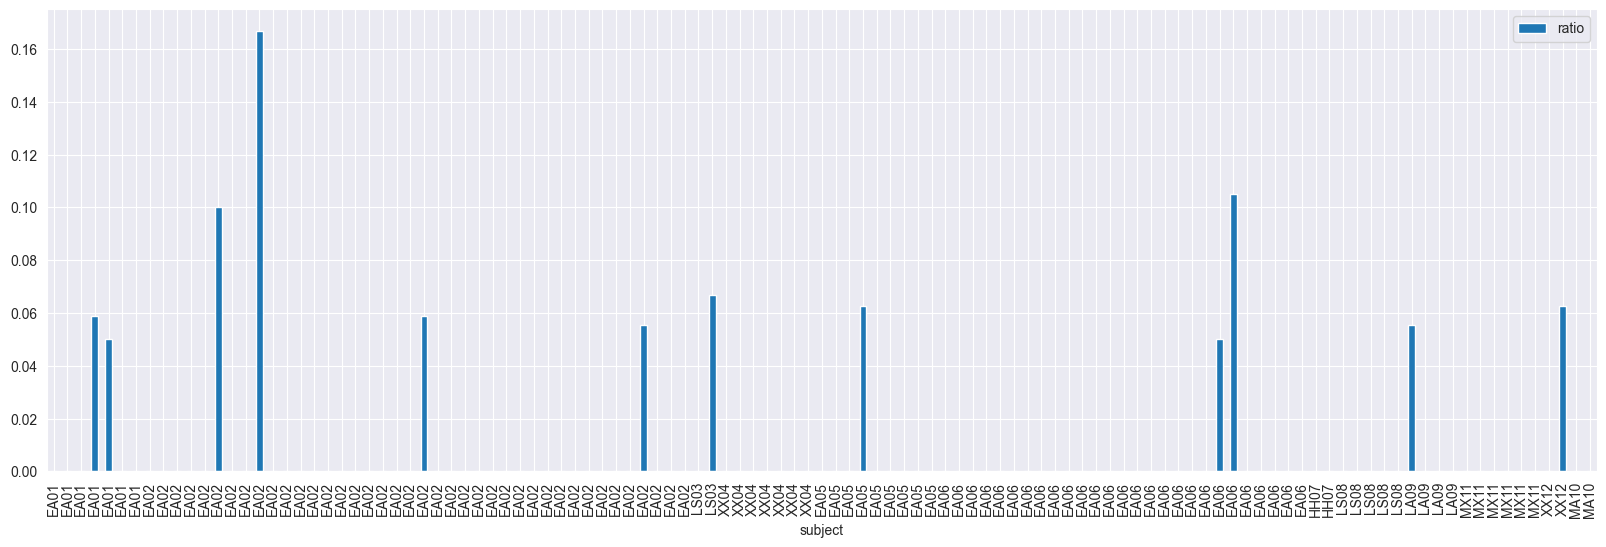

In [42]:
dfSampleLung.plot(kind='bar',x='subject', y='ratio',figsize=(20,6))
plt.savefig(CONFIG.DataDir/'result'/'marker.bar.pdf', bbox_inches='tight')
